# Non-Linear Time Delay Correction

Correction of the time-delay and correct sample rate

For participant S20_2.

Please find the configuration of this experiment in ` experiments/nearest_advocate_windowed/nearest_advocate_config.py`.

In [1]:
import os
# Set the path such that the package can be found locally
os.chdir("/home/jovyan/work/Synchronization/git_nearest_advocate/experiments")
from pathlib import Path

import numpy as np
import pandas as pd

import nearest_advocate

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set(style='whitegrid')
sns.set_context('notebook')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load config and functions for Nearest Advocate
from nearest_advocate_windowed.nearest_advocate_config import TD_MIN, TD_MAX, TD_MID, TD_NEAR, TD_SPS
from nearest_advocate_windowed.nearest_advocate_config import IMG_FORMAT, PATH_SYNCED
from nearest_advocate_windowed.data_loader import read_r_peaks, read_j_peaks, save_j_peaks_corrected
from nearest_advocate_windowed.nearest_advocate_windowed import (
    nearest_advocate_windowed, nearest_advocate_windowed_linear, nearest_advocate_windowed_nonlinear)
from nearest_advocate_windowed.plotting import double_check_sync, create_overlay_plots

In [2]:
# Extracted J-peaks from the BCG
PATH_JPEAKS_FILE = "../data/HeartBeatData/S20_2_beats.csv"  # J-peaks from the uncompressed bcg

# PSG IBI
PATH_IBI_FILE = "../data/HeartBeatData/S20_21_nn.txt"

In [3]:
# set seed
np.random.seed(1)

## Load Ground Truth IBIs

In [4]:
df_r = read_r_peaks(path_rpeaks=PATH_IBI_FILE)
arr_r = df_r["time"].values
print(df_r.shape)
df_r.head()

(30531, 3)


rr   time  stage
0  1.004  1.172      0
1  0.972  2.144      0
2  0.996  3.140      0
3  1.012  4.152      0
4  0.952  5.104      0

## Load J-peaks from the BCG

In [5]:
df_j, arr_j, column_key = read_j_peaks(path_jpeaks=PATH_JPEAKS_FILE,
directory=PATH_SYNCED, sps_rel=1.0, verbose=2)
print(df_j.shape)
df_j.head()

Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time'.
(26550, 4)


time  time_corrected        jj  time_corrected_nonlinear
0  0.000        0.273396       NaN                  0.798149
1  1.820        2.096773  1.823430                  2.621579
2  5.925        6.209390  4.112737                  6.734316
3  7.140        7.426645  1.217290                  7.951606
4  8.060        8.348352  0.921734                  8.873340

## Synchronization ohne Anpassung eines Stückes

In [6]:
time_shifts = nearest_advocate.nearest_advocate(
    arr_ref=arr_r, arr_sig=arr_j[1000:1200],
    td_min=-60, td_max=60, sps=100)
time_shift, min_mean_dist = time_shifts[np.argmin(time_shifts[:,1])]
print(f"Found an optimum at {time_shift:.4f}s with a minimal mean distance of {min_mean_dist:.6f}s")

Found an optimum at 2.3900s with a minimal mean distance of 0.117018s


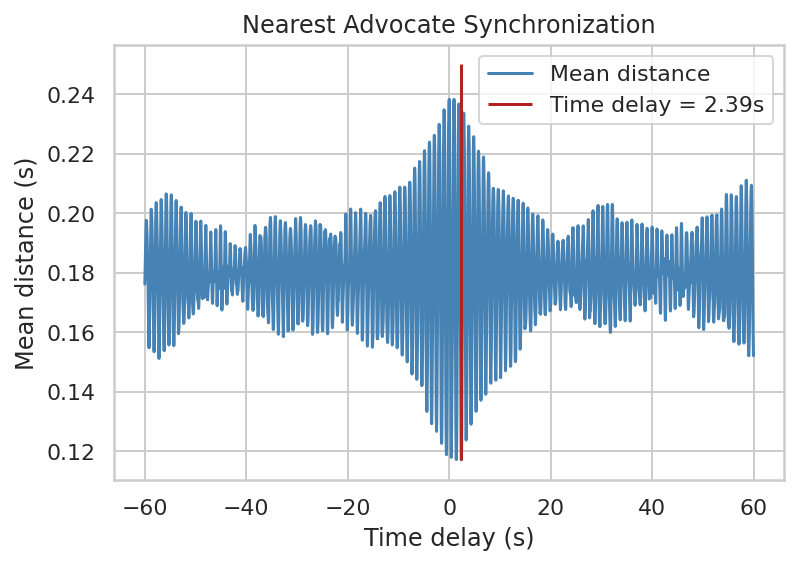

In [7]:
plt.plot(time_shifts[:,0], time_shifts[:,1], color="steelblue", label="Mean distance")
plt.vlines(x=time_shift, ymin=min(time_shifts[:,1]), ymax=0.25, color="firebrick", label=f"Time delay = {time_shift:.2f}s")
# plt.xlim(0, 8)
plt.title("Nearest Advocate Synchronization")
plt.xlabel("Time delay (s)")
plt.ylabel("Mean distance (s)")
plt.legend(loc="upper right")
plt.show()

## Lineare gefensterte Synchronisierung

In [8]:
# remove directory for starting with the original timestamps
save_dir = os.path.join(PATH_SYNCED, Path(PATH_JPEAKS_FILE.split(os.sep)[-1]).with_suffix(""))
if os.path.exists(save_dir):
    for file in os.listdir(save_dir):
        if os.path.isfile(os.path.join(save_dir, file)):
            os.remove(os.path.join(save_dir, file))
else:
    os.mkdir(save_dir)

Loading J-peaks from '../data/HeartBeatData/S20_2_beats.csv' with array from column 'time'.
No corrected time in file, correcting using  sps_rel = 1.0 and td_hat = 0.0 s


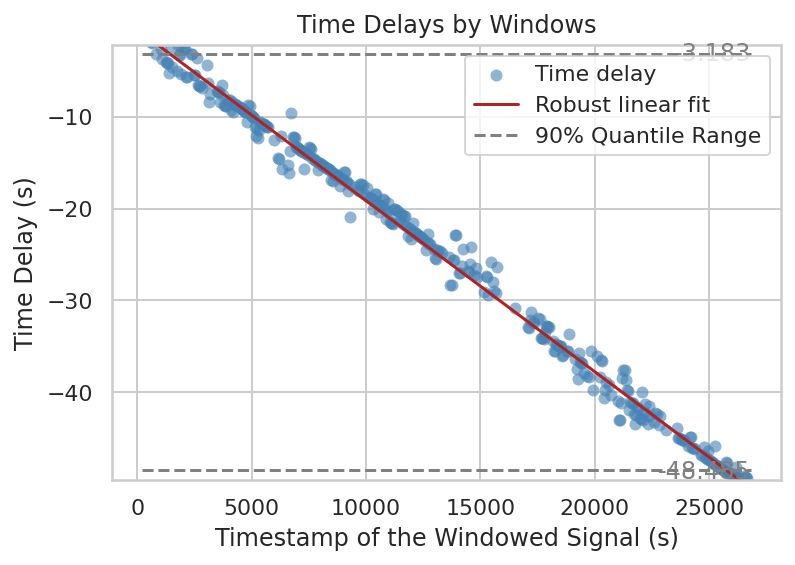

Estimated time-delta of -25.6951 s  (-0.9376 to -50.4525), rel. sps=1.0038,  90% Interval-Range=45.3025 s


In [9]:
df_results, stats, column_key = nearest_advocate_windowed_linear(
    PATH_IBI_FILE, PATH_JPEAKS_FILE, sps_rel=1.001965,
    td_min=-100, td_max=100, td_sps=20, sparse_factor=1, dist_max=0.25,
    frame_length=200, sliding_length=50, bandwidth_filter=None, verbose=2)

## Non-linear correction of windowed Nearest Advocate Optima

Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected'.


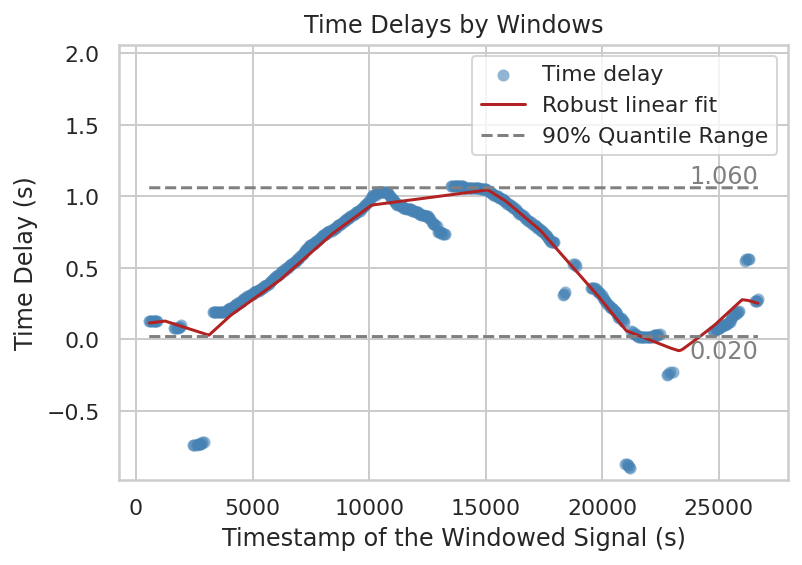

Corrected the time delay with a MLP with MAE=0.0596 s, RMSE=0.1692 s,  90% Interval-Range=1.0400 s


In [10]:
df_results, stats, column_key  = nearest_advocate_windowed_nonlinear(
    PATH_IBI_FILE, PATH_JPEAKS_FILE,
    td_min=-50, td_max=50, td_sps=100, sparse_factor=1, dist_max=0.25,
    frame_length=500, sliding_length=50, bandwidth_filter=5, quantile_filter=0.2,
    weight_decay=1e-5, quantile_range=0.9, verbose=2)

## Manuelle Check of the Results

In [11]:
df_j, arr_j, column_key = read_j_peaks(
    path_jpeaks=PATH_JPEAKS_FILE, directory=PATH_SYNCED,
    array_key=["time_corrected_nonlinear", "time_corrected", "time"])
arr_j_linspace = np.linspace(df_j.iloc[0]["time"], df_j.iloc[-1]["time"], 1_001)  # use the J-peak array for prediction
df_j.head()

Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


time  time_corrected        jj  time_corrected_nonlinear
0  0.000        0.937645       NaN                  0.822909
1  1.820        2.761031  1.823350                  2.646259
2  5.925        6.873670  4.112556                  6.758815
3  7.140        8.090931  1.217236                  7.976051
4  8.060        9.012642  0.921693                  8.897745

### Double-check of the windowed Results

In [12]:
# # Double-check with all data on clock-drift corrected data
# double_check_sync(path_rpeaks=PATH_IBI_FILE, path_jpeaks=PATH_JPEAKS_FILE,
#     array_key=["time_corrected_nonlinear", "time_corrected"],
#     scopes=["broad", "mid", "near"],
#     td_min=-60, td_max=60, td_mid=20, td_near=5,
#     td_sps=100, dist_max=0.25, save_fig=False)

### Check randomized Overlaps

In [13]:
# create_overlay_plots(df_r, df_j, n_plots=10, width=10)

## Iterative Synchronisierungsroutine

In [14]:
def synchronize_jpeaks(path_rpeaks, path_jpeaks, sps_rel=1.0, n_sync_linear=2,
    td_min=-60, td_max=60, td_mid=30, td_near=10, td_sps_min=20, dist_max=0.25,
    frame_length=100, sliding_length=50, verbose=2, save_fig=False):
    """Synchronize an event-based file using the Nearest Advocate algorithm.

    Parameters
    ----------
    path_rpeaks : str
        Path to the sorted r-peak file assumed to be correct (ground truth).
    path_jpeaks : str
        Path to the sorted j-peak file from the BCG, assumed to be shifted by a variable time-delta
    """
    print(f"\n\n####################### Synchronize {path_jpeaks.split(os.sep)[-1]} #######################")

    # assertions
    assert n_sync_linear > 0

    # build save directory, create directory of remove content
    save_dir = os.path.join(PATH_SYNCED, Path(path_jpeaks.split(os.sep)[-1]).with_suffix(""))
    if os.path.exists(save_dir):
        for file in os.listdir(save_dir):
            if os.path.isfile(os.path.join(save_dir, file)):
                os.remove(os.path.join(save_dir, file))
    else:
        os.mkdir(save_dir)

    # Iterations of Linear correction
    stats = {"sps_pred": sps_rel}
    for n_iter in range(1, n_sync_linear+1):
        if n_iter > 1:
            td_min = -td_mid
            td_max = td_mid
        try:
            df_results, stats, column_key = nearest_advocate_windowed_linear(
                path_rpeaks, path_jpeaks, sps_rel=stats['sps_pred'],
                td_min=td_min, td_max=td_max, td_sps=20*n_iter,
                sparse_factor=1, dist_max=0.25,
                frame_length=int(100*n_iter), sliding_length=50, bandwidth_filter=None,
                verbose=verbose, save_fig=os.path.join(save_dir, f"linear_correction_{n_iter}.{IMG_FORMAT}"))
        except ValueError as e:
            print(f"An exception occured by in 'nearest_advocate_windowed': \n{e}")
        print(f"Linear round {n_iter:>2}: relative sps-factor={stats['sps_pred']:>8.6f}, time delay={stats['td_pred_median']:>6.3f} s")

    # Iterations of Non-linear correction
    df_results, stats, column_key = nearest_advocate_windowed_nonlinear(
        PATH_IBI_FILE, PATH_JPEAKS_FILE,
        td_min=-td_mid, td_max=td_mid, td_sps=5*td_sps_min, sparse_factor=1, dist_max=0.25,
        frame_length=500, sliding_length=50, bandwidth_filter=2, quantile_filter=0.2,
        weight_decay=1e-4, verbose=verbose, save_fig=os.path.join(save_dir, f"nonlinear_correction_1.{IMG_FORMAT}"))

    df_results, stats, column_key = nearest_advocate_windowed_nonlinear(
        PATH_IBI_FILE, PATH_JPEAKS_FILE,
        td_min=-td_mid, td_max=td_mid, td_sps=5*td_sps_min, sparse_factor=1, dist_max=0.25,
        frame_length=500, sliding_length=50, bandwidth_filter=1, quantile_filter=0.15,
        weight_decay=1e-5, verbose=verbose, save_fig=os.path.join(save_dir, f"nonlinear_correction_2.{IMG_FORMAT}"))

    df_results, stats, column_key = nearest_advocate_windowed_nonlinear(
        PATH_IBI_FILE, PATH_JPEAKS_FILE,
        td_min=-td_mid, td_max=td_mid, td_sps=10*td_sps_min, sparse_factor=1, dist_max=0.25,
        frame_length=500, sliding_length=50, bandwidth_filter=0.5, quantile_filter=0.1,
        weight_decay=1e-6, verbose=verbose, save_fig=os.path.join(save_dir, f"nonlinear_correction_3.{IMG_FORMAT}"))

    df_results, stats, column_key = nearest_advocate_windowed_nonlinear(
        path_rpeaks, path_jpeaks,
        td_min=-td_mid, td_max=td_mid, td_sps=5*td_sps_min, sparse_factor=1, dist_max=0.25,
        frame_length=500, sliding_length=50, bandwidth_filter=0.5, quantile_filter=0.05,
        weight_decay=1e-7, verbose=verbose, save_fig=os.path.join(save_dir, f"nonlinear_correction_4.{IMG_FORMAT}"))

    # Double-check with all data on nonlinear corrected data
    double_check_sync(path_rpeaks=path_rpeaks, path_jpeaks=path_jpeaks,
        array_key=["time_corrected_nonlinear", "time_corrected"],
        scopes=["broad", "mid", "near"],
        td_min=td_min, td_max=td_max, td_mid=td_mid, td_near=td_near,
        td_sps=5*td_sps_min, dist_max=0.25, save_dir=save_dir)

    # create overlay plots
    df_r = read_r_peaks(path_rpeaks=path_rpeaks)
    df_j, arr_j, column_key = read_j_peaks(path_jpeaks=path_jpeaks, directory=PATH_SYNCED,
                                           array_key=["time_corrected_nonlinear"])
    create_overlay_plots(df_r, df_j, n_plots=10, width=10,
                        save_fig=os.path.join(save_dir, f"comparison.{IMG_FORMAT}"))
    return df_results, stats



####################### Synchronize S20_2_beats.csv #######################
Loading J-peaks from '../data/HeartBeatData/S20_2_beats.csv' with array from column 'time'.
No corrected time in file, correcting using  sps_rel = 1.0 and td_hat = 0.0 s


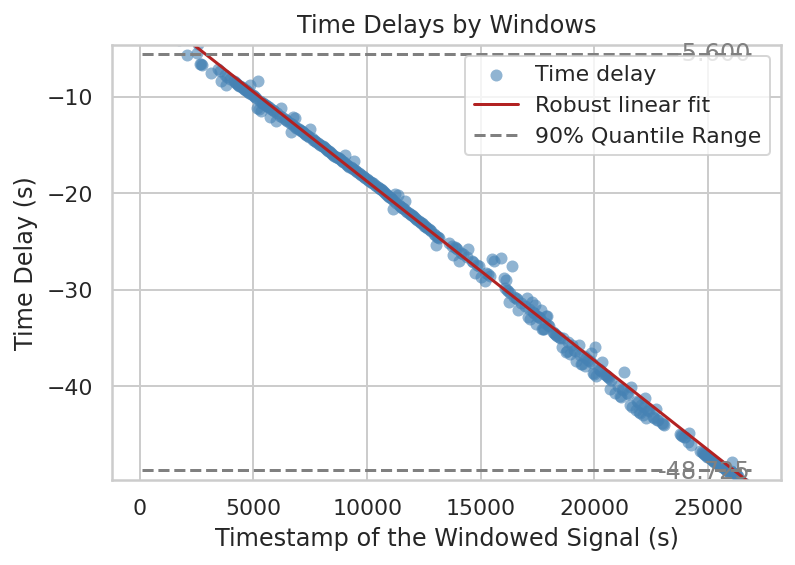

Estimated time-delta of -25.2772 s  (-0.4023 to -50.1521), rel. sps=1.0019,  90% Interval-Range=43.1250 s
Linear round  1: relative sps-factor=1.001858, time delay=-25.277 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected'.


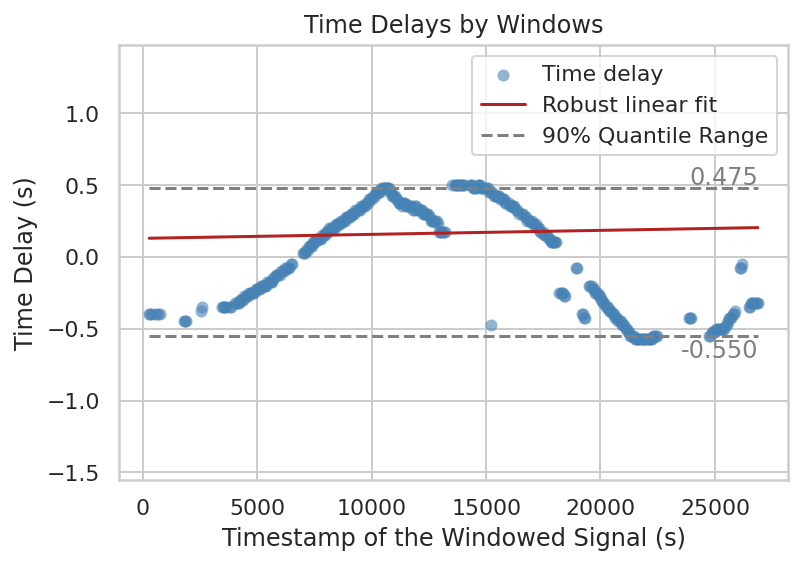

Estimated time-delta of 0.1658 s  (0.1290 to 0.2027), rel. sps=1.0019,  90% Interval-Range=1.0250 s
Linear round  2: relative sps-factor=1.001856, time delay= 0.166 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected'.


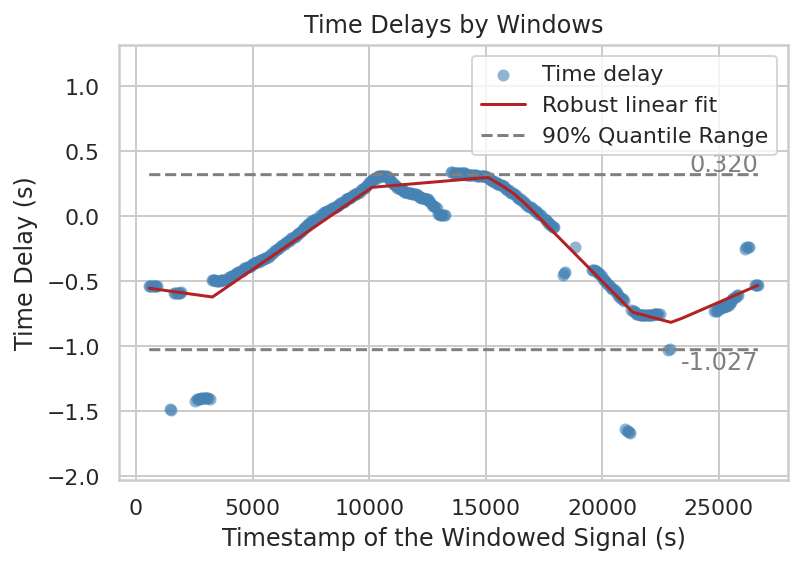

Corrected the time delay with a MLP with MAE=0.0781 s, RMSE=0.2027 s,  90% Interval-Range=1.3470 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


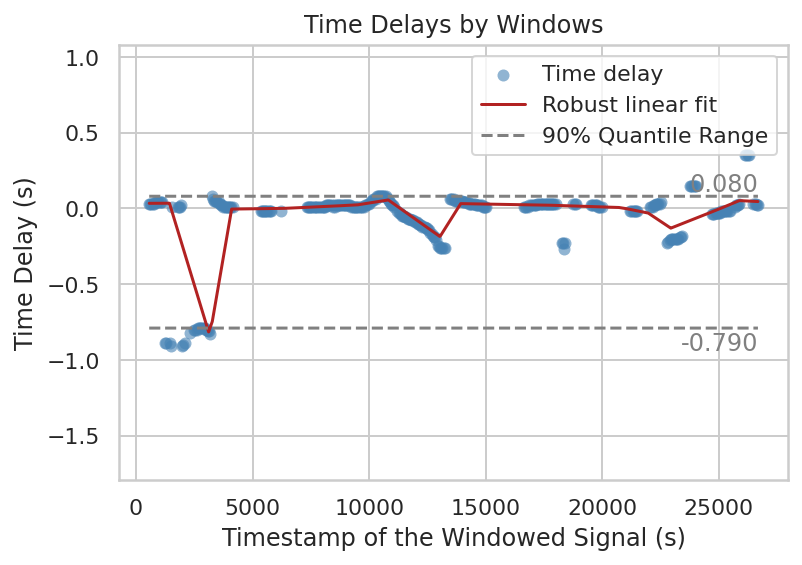

Corrected the time delay with a MLP with MAE=0.0602 s, RMSE=0.1329 s,  90% Interval-Range=0.8700 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


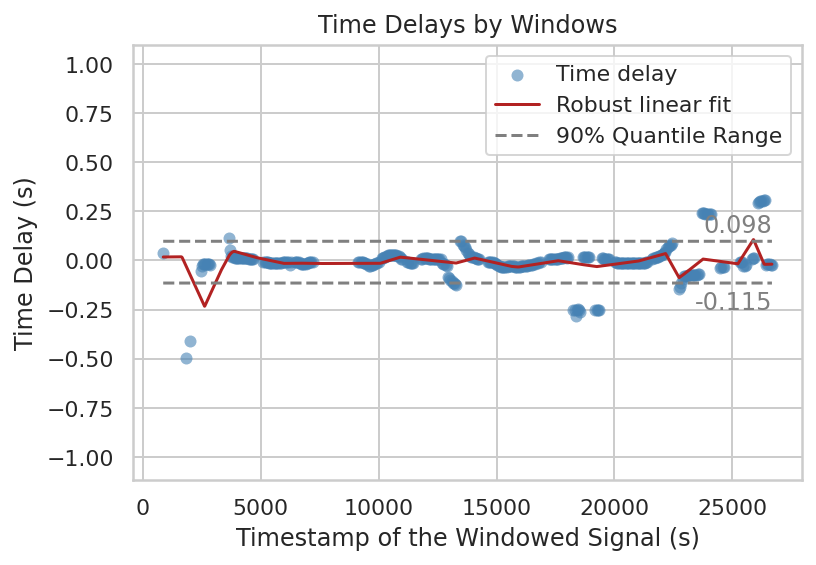

Corrected the time delay with a MLP with MAE=0.0331 s, RMSE=0.0701 s,  90% Interval-Range=0.2125 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


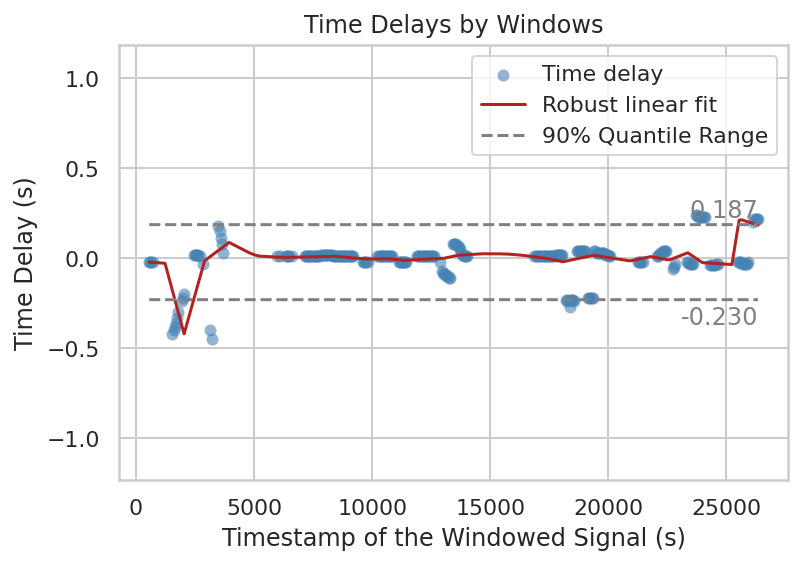

Corrected the time delay with a MLP with MAE=0.0382 s, RMSE=0.0800 s,  90% Interval-Range=0.4170 s
Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.
Found optimum at 0.0000 s, should be at 0.0 s.
Minimum is at 0.076145, others are 0.169114,  ( -> difference of 0.092969)


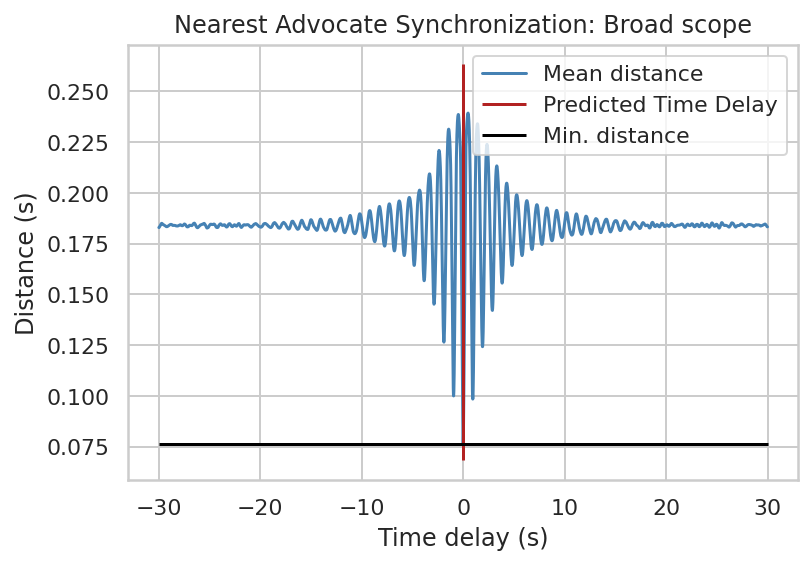

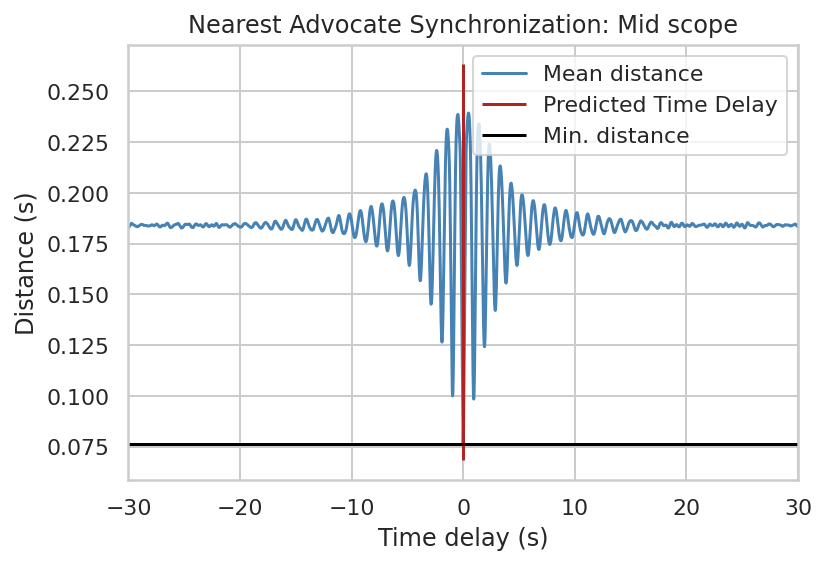

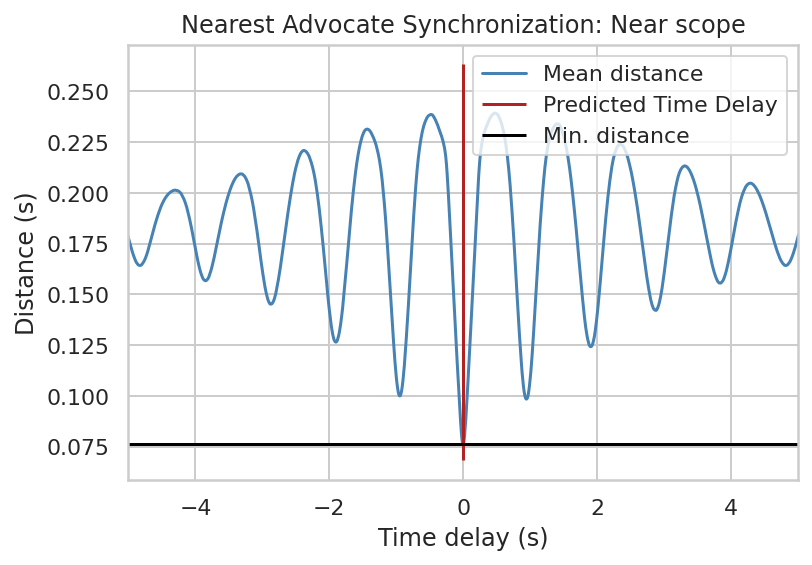

Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


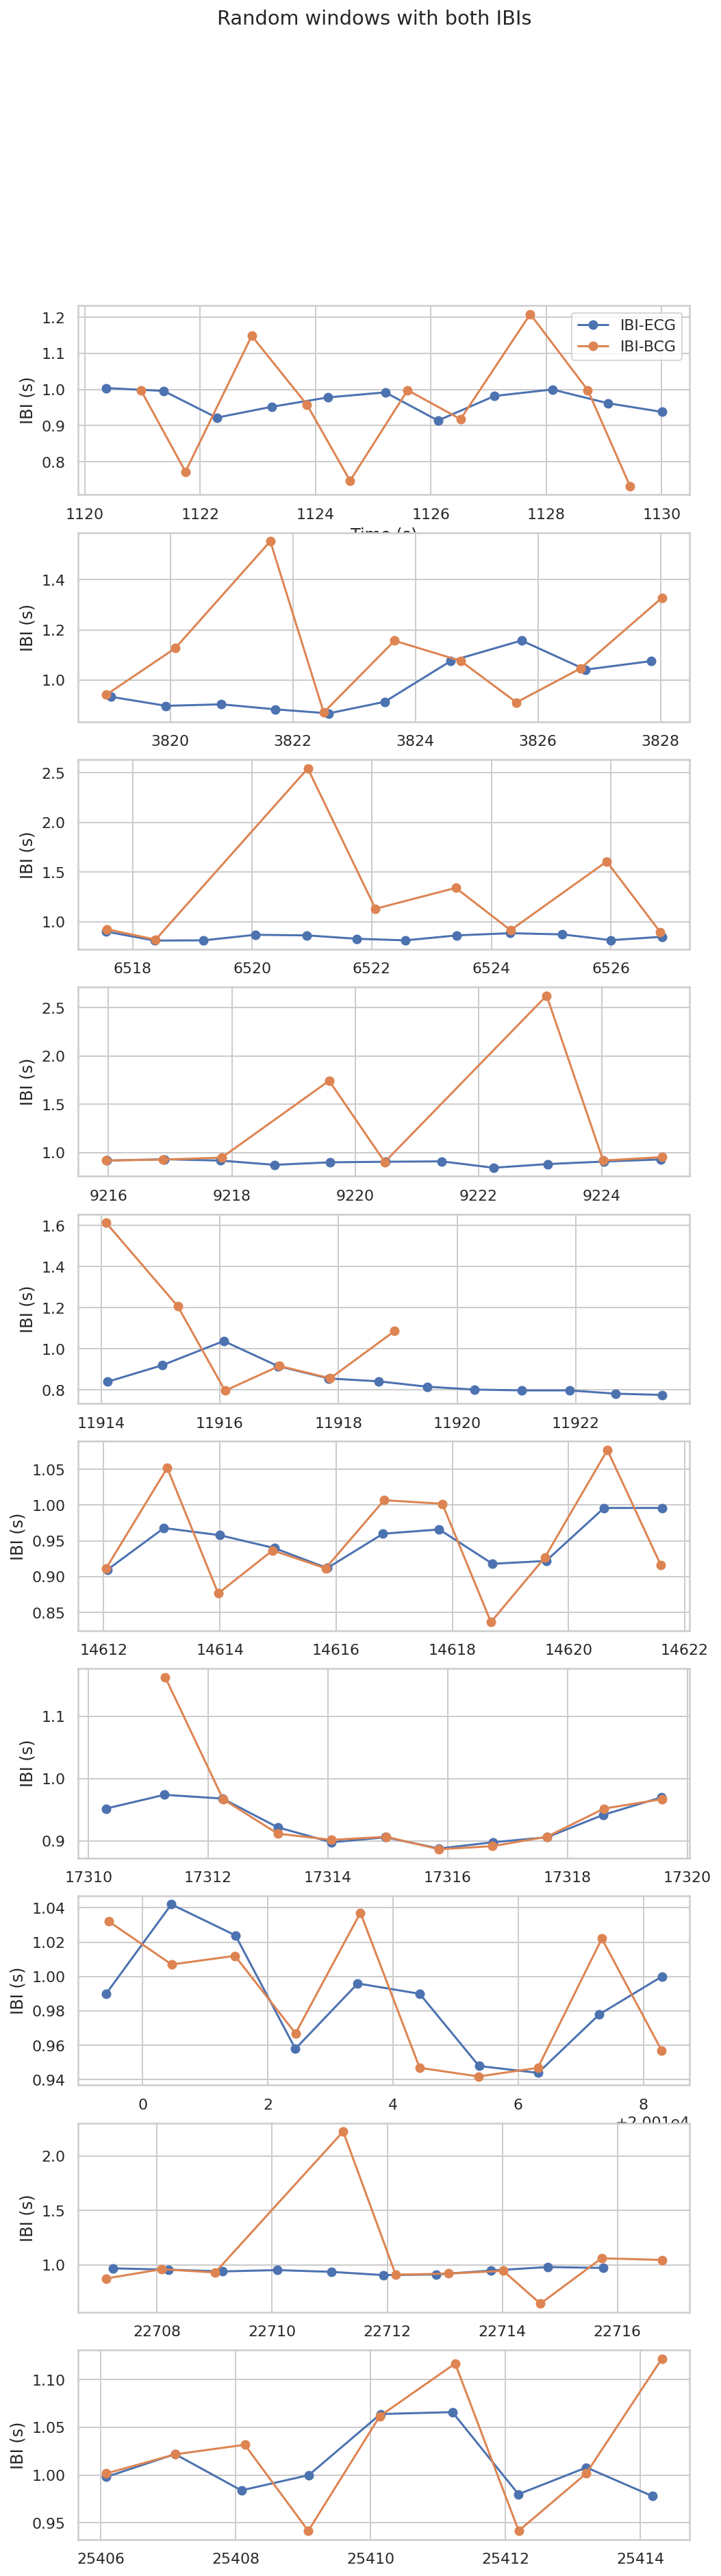

In [15]:
df_results, stats = synchronize_jpeaks(
    PATH_IBI_FILE, PATH_JPEAKS_FILE, sps_rel=1.0,
    td_min=TD_MIN, td_max=TD_MAX, td_mid=TD_MID, td_near=TD_NEAR,
    n_sync_linear=2, verbose=2)

## Plotly Chart

In [16]:
# load the j-peak file from the BCG
df_j, arr_j, column_key = read_j_peaks(path_jpeaks=PATH_JPEAKS_FILE, directory=PATH_SYNCED,
                                       array_key=["time_corrected_nonlinear", "time_corrected"])

Loading J-peaks from '../data/HeartBeat_synched/S20_2_beats/S20_2_beats.csv' with array from column 'time_corrected_nonlinear'.


In [17]:
# Using plotly.express
import plotly.express as px

slice_time = (11_000, 12_000)  # slice the window in this time range
pps = 10  # points per second

# Create the DataFrame
xvals = np.linspace(int(arr_j[0]),
                   int(arr_j[-1]),
                   pps * (int(arr_j[-1])-int(arr_j[0]))+1)

df = pd.DataFrame({"time": xvals})
df["IBI-ECG"] = np.interp(xvals, df_r["time"], df_r["rr"])
df["IBI-BCG"] = np.interp(xvals, df_j["time_corrected_nonlinear"], df_j["jj"])

df = df[np.logical_and(slice_time[0] < df["time"], df["time"] < slice_time[1])]
fig = px.line(df, x='time', y=["IBI-ECG", "IBI-BCG"],
              title="IBI from ECG and BCG",
              labels={
                "value": "IBI (s)",
                "time": "Time (s)",
                "variable": "Line"
              })
fig.show()